In [1]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=2,
            latent_dims=10,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            ß=10,
            modified=False,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

In [2]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8
generating:  9


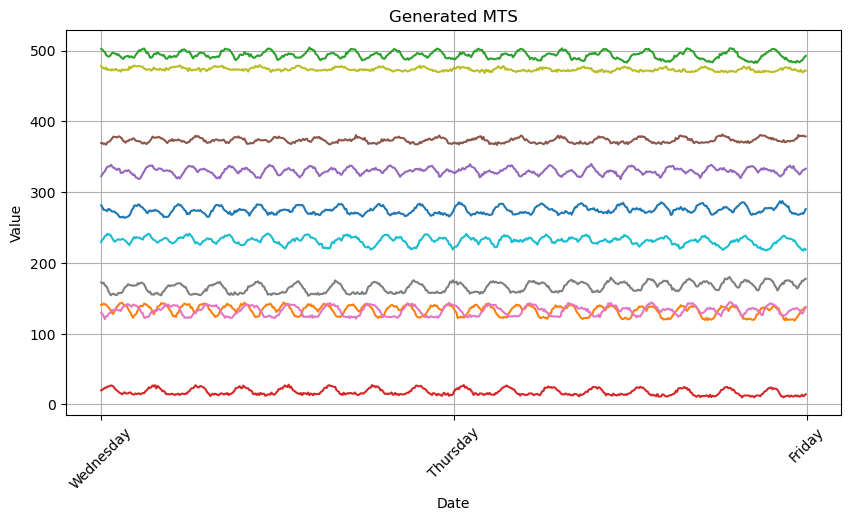

In [3]:
train_data, val_data, test_data, X = generate_labeled_data(args,
                                                           effects,
                                                           effect="both",
                                                           occurance=5,
                                                           return_gen=True,
                                                           anomalies=False)

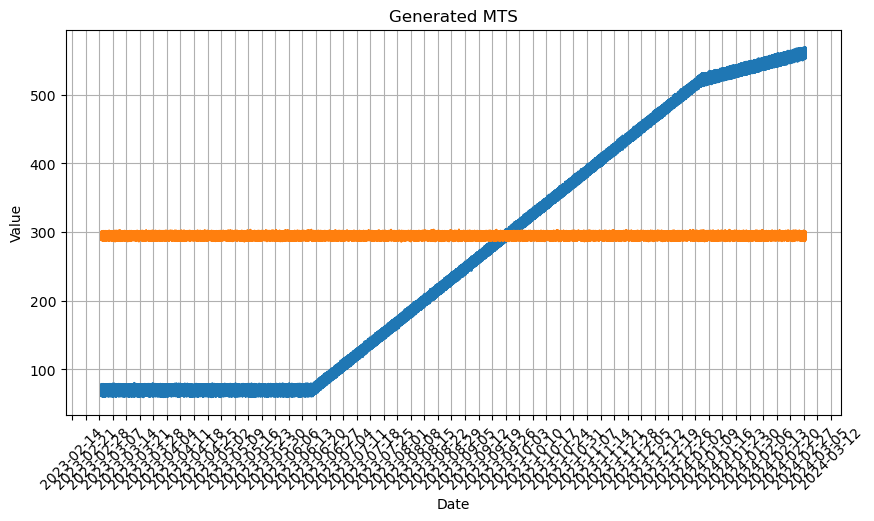

In [4]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=2,
                                                                            return_gen=True,
                                                                            anomalies=False)

In [5]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

In [6]:
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
Origin_vae_norm, REC_vae_norm, _ = rebuild_TS(vae, train_data, args, keep_norm=True)
Origin_vae, REC_vae, z = rebuild_TS(vae, train_data, args, keep_norm=False)

Origin_vq_norm, REC_vq_norm, _ = rebuild_TS(vq, train_data, args, keep_norm=True)
Origin_vq, REC_vq, indices = rebuild_TS(vq, train_data, args, keep_norm=False)
# indices = indices.mean(axis=-1).type(torch.int32)

labels = extract_parameters(args, e_params=e_params, effects=effects)
labels = add_mu_std(labels, params)
train_labels = labels[:Origin_vae_norm.shape[0]]
                      
denoised_rec = denoise_data(REC_vae_norm.cpu())
denoised_orig = denoise_data(Origin_vae_norm.cpu())
train_data_denoised = DataLoader(NoWindow(torch.from_numpy(denoised_orig), args, train_labels, norm=True),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

In [10]:
freqs = get_frequencies_per_week(vae, train_data, args, n=2)

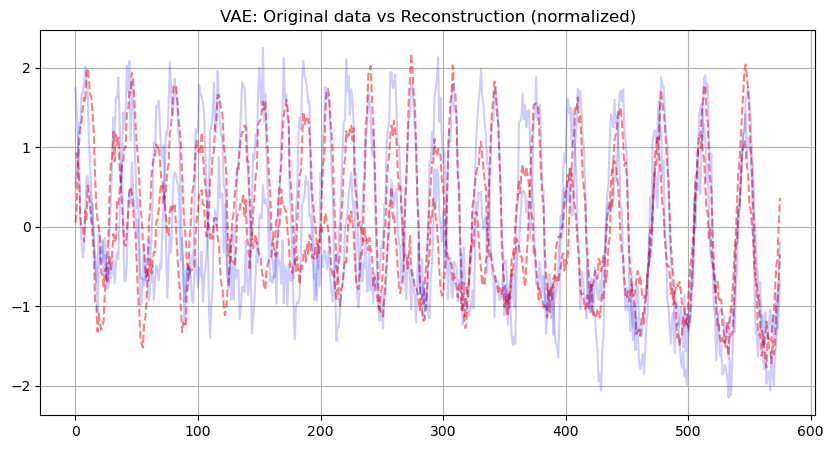

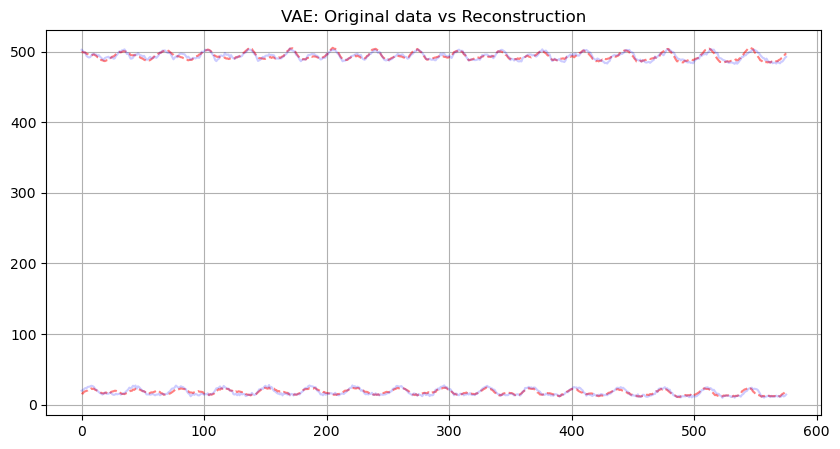

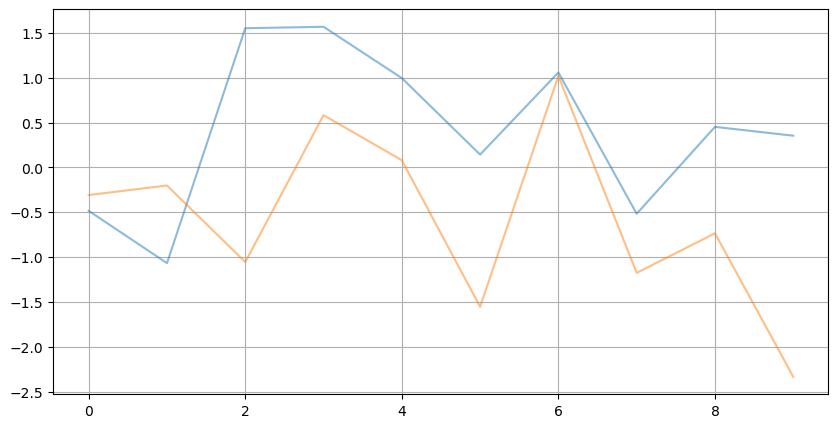

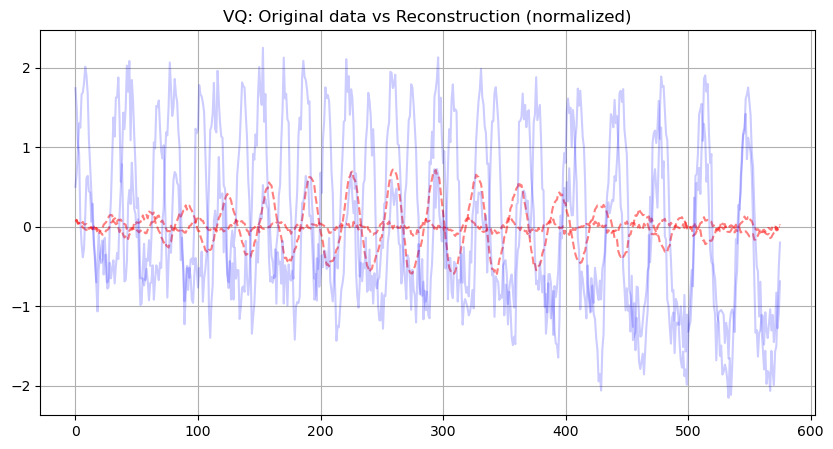

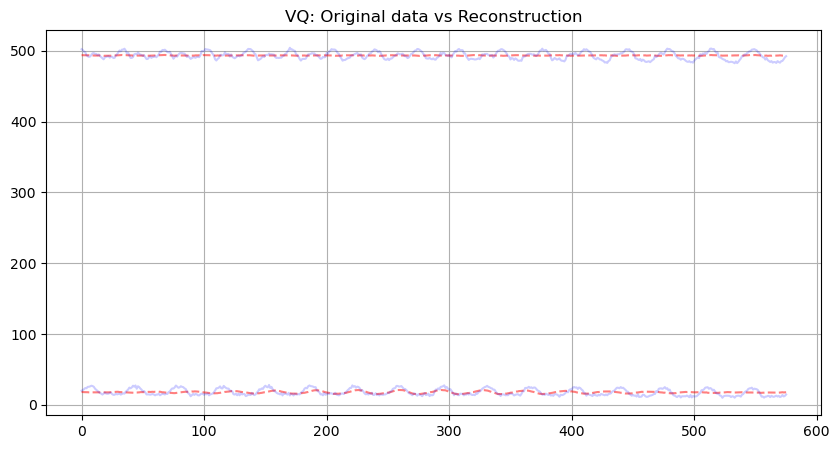

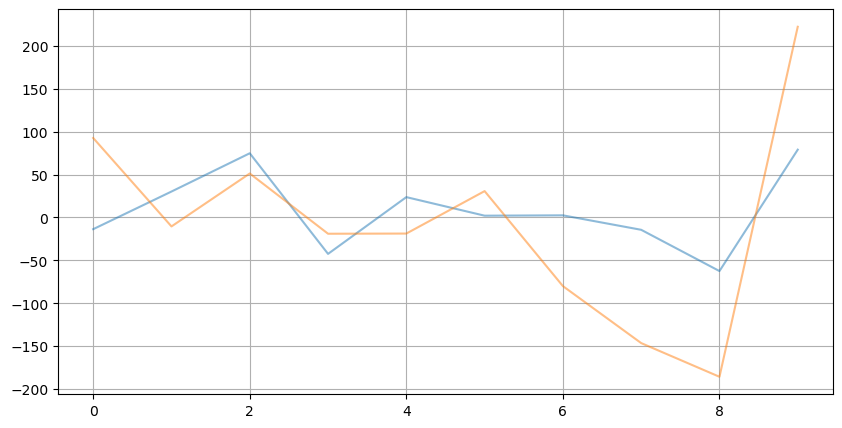

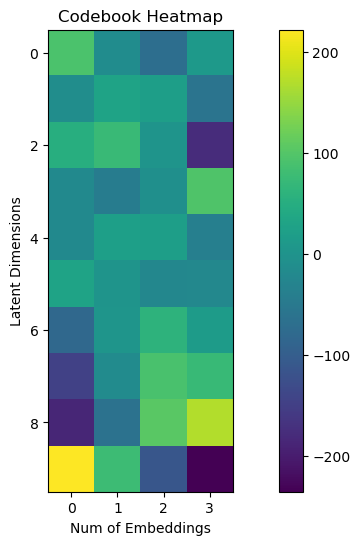

====> VAE: Sample 901 Average loss: 0.5977
====> VQ: Sample 901 Average loss: 1.6187
Train Epoch: 902 [0/4 (0%)]	Loss: 476.161865	 True Loss: 121897.437500
Train Epoch: 902 [0/4 (0%)]	Loss: 1252.639282	 True Loss: 320675.656250
====> VAE: Sample 902 Average loss: 0.5978
====> VQ: Sample 902 Average loss: 1.6229
Train Epoch: 903 [0/4 (0%)]	Loss: 479.144806	 True Loss: 122661.070312
Train Epoch: 903 [0/4 (0%)]	Loss: 1254.044189	 True Loss: 321035.312500
====> VAE: Sample 903 Average loss: 0.5976
====> VQ: Sample 903 Average loss: 1.6275
Train Epoch: 904 [0/4 (0%)]	Loss: 478.862488	 True Loss: 122588.796875
Train Epoch: 904 [0/4 (0%)]	Loss: 1262.754395	 True Loss: 323265.125000
====> VAE: Sample 904 Average loss: 0.5947
====> VQ: Sample 904 Average loss: 1.6206
Train Epoch: 905 [0/4 (0%)]	Loss: 479.385742	 True Loss: 122722.750000
Train Epoch: 905 [0/4 (0%)]	Loss: 1265.106445	 True Loss: 323867.250000
====> VAE: Sample 905 Average loss: 0.5970
====> VQ: Sample 905 Average loss: 1.6183
Tra

====> VAE: Sample 937 Average loss: 0.5933
====> VQ: Sample 937 Average loss: 1.6098
Train Epoch: 938 [0/4 (0%)]	Loss: 481.543121	 True Loss: 123275.039062
Train Epoch: 938 [0/4 (0%)]	Loss: 1253.958252	 True Loss: 321013.312500
====> VAE: Sample 938 Average loss: 0.5945
====> VQ: Sample 938 Average loss: 1.6168
Train Epoch: 939 [0/4 (0%)]	Loss: 479.619080	 True Loss: 122782.484375
Train Epoch: 939 [0/4 (0%)]	Loss: 1254.501831	 True Loss: 321152.468750
====> VAE: Sample 939 Average loss: 0.5961
====> VQ: Sample 939 Average loss: 1.6094
Train Epoch: 940 [0/4 (0%)]	Loss: 479.646057	 True Loss: 122789.390625
Train Epoch: 940 [0/4 (0%)]	Loss: 1253.328857	 True Loss: 320852.187500
====> VAE: Sample 940 Average loss: 0.5983
====> VQ: Sample 940 Average loss: 1.6051
Train Epoch: 941 [0/4 (0%)]	Loss: 483.114899	 True Loss: 123677.414062
Train Epoch: 941 [0/4 (0%)]	Loss: 1241.193726	 True Loss: 317745.593750
====> VAE: Sample 941 Average loss: 0.5970
====> VQ: Sample 941 Average loss: 1.5969
Tra

====> VAE: Sample 973 Average loss: 0.5957
====> VQ: Sample 973 Average loss: 1.6161
Train Epoch: 974 [0/4 (0%)]	Loss: 479.368347	 True Loss: 122718.296875
Train Epoch: 974 [0/4 (0%)]	Loss: 1262.385742	 True Loss: 323170.750000
====> VAE: Sample 974 Average loss: 0.5941
====> VQ: Sample 974 Average loss: 1.6250
Train Epoch: 975 [0/4 (0%)]	Loss: 478.624207	 True Loss: 122527.796875
Train Epoch: 975 [0/4 (0%)]	Loss: 1250.768555	 True Loss: 320196.750000
====> VAE: Sample 975 Average loss: 0.5934
====> VQ: Sample 975 Average loss: 1.6166
Train Epoch: 976 [0/4 (0%)]	Loss: 485.117432	 True Loss: 124190.062500
Train Epoch: 976 [0/4 (0%)]	Loss: 1266.846436	 True Loss: 324312.687500
====> VAE: Sample 976 Average loss: 0.5954
====> VQ: Sample 976 Average loss: 1.6254
Train Epoch: 977 [0/4 (0%)]	Loss: 482.850708	 True Loss: 123609.781250
Train Epoch: 977 [0/4 (0%)]	Loss: 1271.768555	 True Loss: 325572.750000
====> VAE: Sample 977 Average loss: 0.5990
====> VQ: Sample 977 Average loss: 1.6264
Tra

In [4]:
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 1000):
    loss_vae = train(vae, train_data, args, opt_vae, epoch)
    loss_vq = train(vq, train_data, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results(vae, train_data, args)
        show_results(vq, train_data, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
        
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data.dataset)))

In [293]:
class identifier(nn.Module):
    def __init__(self, args, n_layers, output_size):
        super(identifier, self).__init__()   
        
        self.n_channels =  args.n_channels      
        self.slope = args.slope
        self.n_layers = n_layers
        self.input_size = args.enc_out * args.latent_dims
        self.output_size = output_size
        self.lin_layers = nn.ModuleList()
#         self.n = 1
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight, a=0.0, b=1.0)
                m.bias.data.fill_(0.01)
                
        # Linear Layers
        for i in range(0, n_layers):
            
            if i == self.n_layers -1:
                self.lin_layers.append(nn.Linear(self.input_size, self.output_size))
                self.lin_layers.append(nn.LeakyReLU(self.slope, True))
#                 self.lin_layers.append(nn.BatchNorm1d(self.n))
            else:
                self.lin_layers.append(nn.Linear(self.input_size, self.input_size))
                self.lin_layers.append(nn.LeakyReLU(self.slope, True))
#                 self.lin_layers.append(nn.BatchNorm1d(self.n))
        
        self.lin_layers.apply(init_weights)
            
         
    def forward(self, x):
#         print("x input", x.shape)
#         x_shape = x.shape
        x = x.view(x.size(0), -1)
#         print("x before lin", x.shape)
        for i, lin in enumerate(self.lin_layers):
            x = lin(x)        
#         print("x after lin", x.shape)
#         print("x out", x.shape)
#         x = x.view(x.shape[0], -1, self.n_channels)
        return x

def train_identifier_modified(model, id_model, train_loader, optimizer, args, epoch):
    
    device=args.device
    labels_size = id_model.output_size
    n_channels = args.n_channels
    
    id_model.train()
    for p in id_model.parameters():
        p.requires_grad = True
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    train_loss = 0
    y_pred = torch.empty((0, 2*labels_size//n_channels), device=device)
    for batch_idx, (data_tup, label, norm) in enumerate(train_loader):
#         print(data.shape)

        data = pick_data(data_tup, args)
        norm = [n.to(device) for n in norm]
        bs   = data.shape[0]  
        
        x_rec, loss, mu, logvar, mu_rec, logvar_rec, e, indices = model(data, ouput_indices=True)
        label_pred = id_model(e)
#         print(label_pred.shape)
#         print(label.shape)
        
#         label = label[:,:,1].to(device)
        optimizer.zero_grad()
#         data = data.view(-1, data.shape[2], data.shape[3])
        
#         identified = id_model(data)
# #         print(identified.shape)
# #         print(torch.mean(identified, dim=0))
#         print(label[...,1].shape)
        
#         loss = F.mse_loss(torch.mean(identified, dim=0), labels, reduction='mean')
        label = normalize(label, p=1, dim=0)
        loss = F.mse_loss(label_pred, label[...,1], reduction='mean')
#         print(loss.shape)
#         # print(x_rec.shape)
#         # print(data[:, :, 0].shape)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
#         print(y_pred.shape)
        y_pred = torch.cat((y_pred, label_pred), dim = 0) 
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return y_pred


In [296]:
id_mlp_vae = identifier(args=args, n_layers=1, output_size=19)
id_mlp_vq = identifier(args=args, n_layers=1, output_size=19)

id_mlp_vae = id_mlp_vae.to(args.device)
id_mlp_vq = id_mlp_vq.to(args.device)

id_mlp_vae_opt = optim.Adam(id_mlp_vae.parameters(), lr = 0.01)
id_mlp_vq_opt = optim.Adam(id_mlp_vq.parameters(), lr = 0.01)

In [297]:
for epoch in range(1,1000):
    y_train_pred_mlp_vae = train_identifier_modified(vae, id_mlp_vae,train_data, id_mlp_vae_opt, args, epoch)
    y_train_pred_mlp_vq = train_identifier_modified(vq, id_mlp_vq,train_data, id_mlp_vq_opt, args, epoch)

Train Epoch: 1 [0/800 (0%)]	Loss: 0.014876
====> Epoch: 1 Average loss: 0.0184
Train Epoch: 1 [0/800 (0%)]	Loss: 29.786840
====> Epoch: 1 Average loss: 38.1824
Train Epoch: 2 [0/800 (0%)]	Loss: 0.011994
====> Epoch: 2 Average loss: 0.0157
Train Epoch: 2 [0/800 (0%)]	Loss: 19.205320
====> Epoch: 2 Average loss: 26.2739
Train Epoch: 3 [0/800 (0%)]	Loss: 0.010478
====> Epoch: 3 Average loss: 0.0117
Train Epoch: 3 [0/800 (0%)]	Loss: 13.058827
====> Epoch: 3 Average loss: 19.3097
Train Epoch: 4 [0/800 (0%)]	Loss: 0.012109
====> Epoch: 4 Average loss: 0.0116
Train Epoch: 4 [0/800 (0%)]	Loss: 10.393509
====> Epoch: 4 Average loss: 15.1479
Train Epoch: 5 [0/800 (0%)]	Loss: 0.007404
====> Epoch: 5 Average loss: 0.0087
Train Epoch: 5 [0/800 (0%)]	Loss: 7.417964
====> Epoch: 5 Average loss: 11.8444
Train Epoch: 6 [0/800 (0%)]	Loss: 0.007708
====> Epoch: 6 Average loss: 0.0082
Train Epoch: 6 [0/800 (0%)]	Loss: 5.822748
====> Epoch: 6 Average loss: 9.4599
Train Epoch: 7 [0/800 (0%)]	Loss: 0.006273


Train Epoch: 52 [0/800 (0%)]	Loss: 0.000029
====> Epoch: 52 Average loss: 0.0000
Train Epoch: 52 [0/800 (0%)]	Loss: 0.048768
====> Epoch: 52 Average loss: 0.0577
Train Epoch: 53 [0/800 (0%)]	Loss: 0.000028
====> Epoch: 53 Average loss: 0.0000
Train Epoch: 53 [0/800 (0%)]	Loss: 0.048381
====> Epoch: 53 Average loss: 0.0572
Train Epoch: 54 [0/800 (0%)]	Loss: 0.000028
====> Epoch: 54 Average loss: 0.0000
Train Epoch: 54 [0/800 (0%)]	Loss: 0.047919
====> Epoch: 54 Average loss: 0.0566
Train Epoch: 55 [0/800 (0%)]	Loss: 0.000024
====> Epoch: 55 Average loss: 0.0000
Train Epoch: 55 [0/800 (0%)]	Loss: 0.047361
====> Epoch: 55 Average loss: 0.0562
Train Epoch: 56 [0/800 (0%)]	Loss: 0.000027
====> Epoch: 56 Average loss: 0.0000
Train Epoch: 56 [0/800 (0%)]	Loss: 0.047127
====> Epoch: 56 Average loss: 0.0557
Train Epoch: 57 [0/800 (0%)]	Loss: 0.000026
====> Epoch: 57 Average loss: 0.0000
Train Epoch: 57 [0/800 (0%)]	Loss: 0.046764
====> Epoch: 57 Average loss: 0.0552
Train Epoch: 58 [0/800 (0%)]

====> Epoch: 102 Average loss: 0.0392
Train Epoch: 103 [0/800 (0%)]	Loss: 0.000018
====> Epoch: 103 Average loss: 0.0000
Train Epoch: 103 [0/800 (0%)]	Loss: 0.033513
====> Epoch: 103 Average loss: 0.0390
Train Epoch: 104 [0/800 (0%)]	Loss: 0.000019
====> Epoch: 104 Average loss: 0.0000
Train Epoch: 104 [0/800 (0%)]	Loss: 0.033110
====> Epoch: 104 Average loss: 0.0387
Train Epoch: 105 [0/800 (0%)]	Loss: 0.000018
====> Epoch: 105 Average loss: 0.0000
Train Epoch: 105 [0/800 (0%)]	Loss: 0.032885
====> Epoch: 105 Average loss: 0.0384
Train Epoch: 106 [0/800 (0%)]	Loss: 0.000018
====> Epoch: 106 Average loss: 0.0000
Train Epoch: 106 [0/800 (0%)]	Loss: 0.032916
====> Epoch: 106 Average loss: 0.0382
Train Epoch: 107 [0/800 (0%)]	Loss: 0.000018
====> Epoch: 107 Average loss: 0.0000
Train Epoch: 107 [0/800 (0%)]	Loss: 0.032328
====> Epoch: 107 Average loss: 0.0379
Train Epoch: 108 [0/800 (0%)]	Loss: 0.000018
====> Epoch: 108 Average loss: 0.0000
Train Epoch: 108 [0/800 (0%)]	Loss: 0.032363
====

Train Epoch: 152 [0/800 (0%)]	Loss: 0.024248
====> Epoch: 152 Average loss: 0.0283
Train Epoch: 153 [0/800 (0%)]	Loss: 0.000015
====> Epoch: 153 Average loss: 0.0000
Train Epoch: 153 [0/800 (0%)]	Loss: 0.024067
====> Epoch: 153 Average loss: 0.0282
Train Epoch: 154 [0/800 (0%)]	Loss: 0.000014
====> Epoch: 154 Average loss: 0.0000
Train Epoch: 154 [0/800 (0%)]	Loss: 0.023861
====> Epoch: 154 Average loss: 0.0280
Train Epoch: 155 [0/800 (0%)]	Loss: 0.000015
====> Epoch: 155 Average loss: 0.0000
Train Epoch: 155 [0/800 (0%)]	Loss: 0.023778
====> Epoch: 155 Average loss: 0.0277
Train Epoch: 156 [0/800 (0%)]	Loss: 0.000014
====> Epoch: 156 Average loss: 0.0000
Train Epoch: 156 [0/800 (0%)]	Loss: 0.023560
====> Epoch: 156 Average loss: 0.0276
Train Epoch: 157 [0/800 (0%)]	Loss: 0.000014
====> Epoch: 157 Average loss: 0.0000
Train Epoch: 157 [0/800 (0%)]	Loss: 0.023541
====> Epoch: 157 Average loss: 0.0275
Train Epoch: 158 [0/800 (0%)]	Loss: 0.000014
====> Epoch: 158 Average loss: 0.0000
Trai

====> Epoch: 202 Average loss: 0.0000
Train Epoch: 202 [0/800 (0%)]	Loss: 0.017774
====> Epoch: 202 Average loss: 0.0208
Train Epoch: 203 [0/800 (0%)]	Loss: 0.000011
====> Epoch: 203 Average loss: 0.0000
Train Epoch: 203 [0/800 (0%)]	Loss: 0.017589
====> Epoch: 203 Average loss: 0.0207
Train Epoch: 204 [0/800 (0%)]	Loss: 0.000011
====> Epoch: 204 Average loss: 0.0000
Train Epoch: 204 [0/800 (0%)]	Loss: 0.017534
====> Epoch: 204 Average loss: 0.0206
Train Epoch: 205 [0/800 (0%)]	Loss: 0.000010
====> Epoch: 205 Average loss: 0.0000
Train Epoch: 205 [0/800 (0%)]	Loss: 0.017333
====> Epoch: 205 Average loss: 0.0204
Train Epoch: 206 [0/800 (0%)]	Loss: 0.000011
====> Epoch: 206 Average loss: 0.0000
Train Epoch: 206 [0/800 (0%)]	Loss: 0.017312
====> Epoch: 206 Average loss: 0.0203
Train Epoch: 207 [0/800 (0%)]	Loss: 0.000010
====> Epoch: 207 Average loss: 0.0000
Train Epoch: 207 [0/800 (0%)]	Loss: 0.017116
====> Epoch: 207 Average loss: 0.0202
Train Epoch: 208 [0/800 (0%)]	Loss: 0.000011
====

Train Epoch: 252 [0/800 (0%)]	Loss: 0.000008
====> Epoch: 252 Average loss: 0.0000
Train Epoch: 252 [0/800 (0%)]	Loss: 0.012892
====> Epoch: 252 Average loss: 0.0152
Train Epoch: 253 [0/800 (0%)]	Loss: 0.000008
====> Epoch: 253 Average loss: 0.0000
Train Epoch: 253 [0/800 (0%)]	Loss: 0.012846
====> Epoch: 253 Average loss: 0.0151
Train Epoch: 254 [0/800 (0%)]	Loss: 0.000008
====> Epoch: 254 Average loss: 0.0000
Train Epoch: 254 [0/800 (0%)]	Loss: 0.012764
====> Epoch: 254 Average loss: 0.0151
Train Epoch: 255 [0/800 (0%)]	Loss: 0.000008
====> Epoch: 255 Average loss: 0.0000
Train Epoch: 255 [0/800 (0%)]	Loss: 0.012680
====> Epoch: 255 Average loss: 0.0149
Train Epoch: 256 [0/800 (0%)]	Loss: 0.000008
====> Epoch: 256 Average loss: 0.0000
Train Epoch: 256 [0/800 (0%)]	Loss: 0.012603
====> Epoch: 256 Average loss: 0.0149
Train Epoch: 257 [0/800 (0%)]	Loss: 0.000008
====> Epoch: 257 Average loss: 0.0000
Train Epoch: 257 [0/800 (0%)]	Loss: 0.012524
====> Epoch: 257 Average loss: 0.0148
Trai

Train Epoch: 301 [0/800 (0%)]	Loss: 0.009414
====> Epoch: 301 Average loss: 0.0112
Train Epoch: 302 [0/800 (0%)]	Loss: 0.000006
====> Epoch: 302 Average loss: 0.0000
Train Epoch: 302 [0/800 (0%)]	Loss: 0.009267
====> Epoch: 302 Average loss: 0.0111
Train Epoch: 303 [0/800 (0%)]	Loss: 0.000006
====> Epoch: 303 Average loss: 0.0000
Train Epoch: 303 [0/800 (0%)]	Loss: 0.009254
====> Epoch: 303 Average loss: 0.0110
Train Epoch: 304 [0/800 (0%)]	Loss: 0.000005
====> Epoch: 304 Average loss: 0.0000
Train Epoch: 304 [0/800 (0%)]	Loss: 0.009232
====> Epoch: 304 Average loss: 0.0109
Train Epoch: 305 [0/800 (0%)]	Loss: 0.000006
====> Epoch: 305 Average loss: 0.0000
Train Epoch: 305 [0/800 (0%)]	Loss: 0.009120
====> Epoch: 305 Average loss: 0.0108
Train Epoch: 306 [0/800 (0%)]	Loss: 0.000005
====> Epoch: 306 Average loss: 0.0000
Train Epoch: 306 [0/800 (0%)]	Loss: 0.009139
====> Epoch: 306 Average loss: 0.0108
Train Epoch: 307 [0/800 (0%)]	Loss: 0.000005
====> Epoch: 307 Average loss: 0.0000
Trai

Train Epoch: 351 [0/800 (0%)]	Loss: 0.006732
====> Epoch: 351 Average loss: 0.0080
Train Epoch: 352 [0/800 (0%)]	Loss: 0.000004
====> Epoch: 352 Average loss: 0.0000
Train Epoch: 352 [0/800 (0%)]	Loss: 0.006687
====> Epoch: 352 Average loss: 0.0080
Train Epoch: 353 [0/800 (0%)]	Loss: 0.000004
====> Epoch: 353 Average loss: 0.0000
Train Epoch: 353 [0/800 (0%)]	Loss: 0.006643
====> Epoch: 353 Average loss: 0.0079
Train Epoch: 354 [0/800 (0%)]	Loss: 0.000004
====> Epoch: 354 Average loss: 0.0000
Train Epoch: 354 [0/800 (0%)]	Loss: 0.006599
====> Epoch: 354 Average loss: 0.0079
Train Epoch: 355 [0/800 (0%)]	Loss: 0.000004
====> Epoch: 355 Average loss: 0.0000
Train Epoch: 355 [0/800 (0%)]	Loss: 0.006555
====> Epoch: 355 Average loss: 0.0078
Train Epoch: 356 [0/800 (0%)]	Loss: 0.000004
====> Epoch: 356 Average loss: 0.0000
Train Epoch: 356 [0/800 (0%)]	Loss: 0.006566
====> Epoch: 356 Average loss: 0.0077
Train Epoch: 357 [0/800 (0%)]	Loss: 0.000004
====> Epoch: 357 Average loss: 0.0000
Trai

Train Epoch: 401 [0/800 (0%)]	Loss: 0.000003
====> Epoch: 401 Average loss: 0.0000
Train Epoch: 401 [0/800 (0%)]	Loss: 0.004826
====> Epoch: 401 Average loss: 0.0058
Train Epoch: 402 [0/800 (0%)]	Loss: 0.000003
====> Epoch: 402 Average loss: 0.0000
Train Epoch: 402 [0/800 (0%)]	Loss: 0.004795
====> Epoch: 402 Average loss: 0.0057
Train Epoch: 403 [0/800 (0%)]	Loss: 0.000002
====> Epoch: 403 Average loss: 0.0000
Train Epoch: 403 [0/800 (0%)]	Loss: 0.004739
====> Epoch: 403 Average loss: 0.0057
Train Epoch: 404 [0/800 (0%)]	Loss: 0.000002
====> Epoch: 404 Average loss: 0.0000
Train Epoch: 404 [0/800 (0%)]	Loss: 0.004724
====> Epoch: 404 Average loss: 0.0056
Train Epoch: 405 [0/800 (0%)]	Loss: 0.000002
====> Epoch: 405 Average loss: 0.0000
Train Epoch: 405 [0/800 (0%)]	Loss: 0.004680
====> Epoch: 405 Average loss: 0.0056
Train Epoch: 406 [0/800 (0%)]	Loss: 0.000002
====> Epoch: 406 Average loss: 0.0000
Train Epoch: 406 [0/800 (0%)]	Loss: 0.004682
====> Epoch: 406 Average loss: 0.0056
Trai

Train Epoch: 450 [0/800 (0%)]	Loss: 0.003423
====> Epoch: 450 Average loss: 0.0041
Train Epoch: 451 [0/800 (0%)]	Loss: 0.000002
====> Epoch: 451 Average loss: 0.0000
Train Epoch: 451 [0/800 (0%)]	Loss: 0.003420
====> Epoch: 451 Average loss: 0.0041
Train Epoch: 452 [0/800 (0%)]	Loss: 0.000002
====> Epoch: 452 Average loss: 0.0000
Train Epoch: 452 [0/800 (0%)]	Loss: 0.003393
====> Epoch: 452 Average loss: 0.0041
Train Epoch: 453 [0/800 (0%)]	Loss: 0.000002
====> Epoch: 453 Average loss: 0.0000
Train Epoch: 453 [0/800 (0%)]	Loss: 0.003355
====> Epoch: 453 Average loss: 0.0040
Train Epoch: 454 [0/800 (0%)]	Loss: 0.000002
====> Epoch: 454 Average loss: 0.0000
Train Epoch: 454 [0/800 (0%)]	Loss: 0.003337
====> Epoch: 454 Average loss: 0.0040
Train Epoch: 455 [0/800 (0%)]	Loss: 0.000002
====> Epoch: 455 Average loss: 0.0000
Train Epoch: 455 [0/800 (0%)]	Loss: 0.003308
====> Epoch: 455 Average loss: 0.0040
Train Epoch: 456 [0/800 (0%)]	Loss: 0.000002
====> Epoch: 456 Average loss: 0.0000
Trai

Train Epoch: 500 [0/800 (0%)]	Loss: 0.002444
====> Epoch: 500 Average loss: 0.0029
Train Epoch: 501 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 501 Average loss: 0.0000
Train Epoch: 501 [0/800 (0%)]	Loss: 0.002418
====> Epoch: 501 Average loss: 0.0029
Train Epoch: 502 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 502 Average loss: 0.0000
Train Epoch: 502 [0/800 (0%)]	Loss: 0.002391
====> Epoch: 502 Average loss: 0.0029
Train Epoch: 503 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 503 Average loss: 0.0000
Train Epoch: 503 [0/800 (0%)]	Loss: 0.002398
====> Epoch: 503 Average loss: 0.0028
Train Epoch: 504 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 504 Average loss: 0.0000
Train Epoch: 504 [0/800 (0%)]	Loss: 0.002382
====> Epoch: 504 Average loss: 0.0028
Train Epoch: 505 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 505 Average loss: 0.0000
Train Epoch: 505 [0/800 (0%)]	Loss: 0.002367
====> Epoch: 505 Average loss: 0.0028
Train Epoch: 506 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 506 Average loss: 0.0000
Trai

Train Epoch: 550 [0/800 (0%)]	Loss: 0.001764
====> Epoch: 550 Average loss: 0.0021
Train Epoch: 551 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 551 Average loss: 0.0000
Train Epoch: 551 [0/800 (0%)]	Loss: 0.001752
====> Epoch: 551 Average loss: 0.0021
Train Epoch: 552 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 552 Average loss: 0.0000
Train Epoch: 552 [0/800 (0%)]	Loss: 0.001752
====> Epoch: 552 Average loss: 0.0021
Train Epoch: 553 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 553 Average loss: 0.0000
Train Epoch: 553 [0/800 (0%)]	Loss: 0.001741
====> Epoch: 553 Average loss: 0.0021
Train Epoch: 554 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 554 Average loss: 0.0000
Train Epoch: 554 [0/800 (0%)]	Loss: 0.001724
====> Epoch: 554 Average loss: 0.0021
Train Epoch: 555 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 555 Average loss: 0.0000
Train Epoch: 555 [0/800 (0%)]	Loss: 0.001709
====> Epoch: 555 Average loss: 0.0021
Train Epoch: 556 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 556 Average loss: 0.0000
Trai

====> Epoch: 600 Average loss: 0.0000
Train Epoch: 600 [0/800 (0%)]	Loss: 0.001320
====> Epoch: 600 Average loss: 0.0016
Train Epoch: 601 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 601 Average loss: 0.0000
Train Epoch: 601 [0/800 (0%)]	Loss: 0.001300
====> Epoch: 601 Average loss: 0.0016
Train Epoch: 602 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 602 Average loss: 0.0000
Train Epoch: 602 [0/800 (0%)]	Loss: 0.001296
====> Epoch: 602 Average loss: 0.0015
Train Epoch: 603 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 603 Average loss: 0.0000
Train Epoch: 603 [0/800 (0%)]	Loss: 0.001302
====> Epoch: 603 Average loss: 0.0016
Train Epoch: 604 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 604 Average loss: 0.0000
Train Epoch: 604 [0/800 (0%)]	Loss: 0.001283
====> Epoch: 604 Average loss: 0.0016
Train Epoch: 605 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 605 Average loss: 0.0000
Train Epoch: 605 [0/800 (0%)]	Loss: 0.001272
====> Epoch: 605 Average loss: 0.0016
Train Epoch: 606 [0/800 (0%)]	Loss: 0.000001
====

====> Epoch: 649 Average loss: 0.0012
Train Epoch: 650 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 650 Average loss: 0.0000
Train Epoch: 650 [0/800 (0%)]	Loss: 0.001021
====> Epoch: 650 Average loss: 0.0012
Train Epoch: 651 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 651 Average loss: 0.0000
Train Epoch: 651 [0/800 (0%)]	Loss: 0.001012
====> Epoch: 651 Average loss: 0.0012
Train Epoch: 652 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 652 Average loss: 0.0000
Train Epoch: 652 [0/800 (0%)]	Loss: 0.001002
====> Epoch: 652 Average loss: 0.0012
Train Epoch: 653 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 653 Average loss: 0.0000
Train Epoch: 653 [0/800 (0%)]	Loss: 0.001005
====> Epoch: 653 Average loss: 0.0012
Train Epoch: 654 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 654 Average loss: 0.0000
Train Epoch: 654 [0/800 (0%)]	Loss: 0.001001
====> Epoch: 654 Average loss: 0.0012
Train Epoch: 655 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 655 Average loss: 0.0000
Train Epoch: 655 [0/800 (0%)]	Loss: 0.000997
====

Train Epoch: 699 [0/800 (0%)]	Loss: 0.001065
====> Epoch: 699 Average loss: 0.0013
Train Epoch: 700 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 700 Average loss: 0.0000
Train Epoch: 700 [0/800 (0%)]	Loss: 0.001069
====> Epoch: 700 Average loss: 0.0013
Train Epoch: 701 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 701 Average loss: 0.0000
Train Epoch: 701 [0/800 (0%)]	Loss: 0.001036
====> Epoch: 701 Average loss: 0.0013
Train Epoch: 702 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 702 Average loss: 0.0000
Train Epoch: 702 [0/800 (0%)]	Loss: 0.001035
====> Epoch: 702 Average loss: 0.0012
Train Epoch: 703 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 703 Average loss: 0.0000
Train Epoch: 703 [0/800 (0%)]	Loss: 0.001023
====> Epoch: 703 Average loss: 0.0012
Train Epoch: 704 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 704 Average loss: 0.0000
Train Epoch: 704 [0/800 (0%)]	Loss: 0.000999
====> Epoch: 704 Average loss: 0.0012
Train Epoch: 705 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 705 Average loss: 0.0000
Trai

Train Epoch: 749 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 749 Average loss: 0.0000
Train Epoch: 749 [0/800 (0%)]	Loss: 0.000713
====> Epoch: 749 Average loss: 0.0008
Train Epoch: 750 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 750 Average loss: 0.0000
Train Epoch: 750 [0/800 (0%)]	Loss: 0.000705
====> Epoch: 750 Average loss: 0.0009
Train Epoch: 751 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 751 Average loss: 0.0000
Train Epoch: 751 [0/800 (0%)]	Loss: 0.000708
====> Epoch: 751 Average loss: 0.0009
Train Epoch: 752 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 752 Average loss: 0.0000
Train Epoch: 752 [0/800 (0%)]	Loss: 0.000706
====> Epoch: 752 Average loss: 0.0009
Train Epoch: 753 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 753 Average loss: 0.0000
Train Epoch: 753 [0/800 (0%)]	Loss: 0.000698
====> Epoch: 753 Average loss: 0.0008
Train Epoch: 754 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 754 Average loss: 0.0000
Train Epoch: 754 [0/800 (0%)]	Loss: 0.000690
====> Epoch: 754 Average loss: 0.0008
Trai

====> Epoch: 798 Average loss: 0.0007
Train Epoch: 799 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 799 Average loss: 0.0000
Train Epoch: 799 [0/800 (0%)]	Loss: 0.000594
====> Epoch: 799 Average loss: 0.0007
Train Epoch: 800 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 800 Average loss: 0.0000
Train Epoch: 800 [0/800 (0%)]	Loss: 0.000588
====> Epoch: 800 Average loss: 0.0007
Train Epoch: 801 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 801 Average loss: 0.0000
Train Epoch: 801 [0/800 (0%)]	Loss: 0.000588
====> Epoch: 801 Average loss: 0.0007
Train Epoch: 802 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 802 Average loss: 0.0000
Train Epoch: 802 [0/800 (0%)]	Loss: 0.000590
====> Epoch: 802 Average loss: 0.0007
Train Epoch: 803 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 803 Average loss: 0.0000
Train Epoch: 803 [0/800 (0%)]	Loss: 0.000594
====> Epoch: 803 Average loss: 0.0007
Train Epoch: 804 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 804 Average loss: 0.0000
Train Epoch: 804 [0/800 (0%)]	Loss: 0.000586
====

Train Epoch: 848 [0/800 (0%)]	Loss: 0.000515
====> Epoch: 848 Average loss: 0.0006
Train Epoch: 849 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 849 Average loss: 0.0000
Train Epoch: 849 [0/800 (0%)]	Loss: 0.000523
====> Epoch: 849 Average loss: 0.0006
Train Epoch: 850 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 850 Average loss: 0.0000
Train Epoch: 850 [0/800 (0%)]	Loss: 0.000516
====> Epoch: 850 Average loss: 0.0006
Train Epoch: 851 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 851 Average loss: 0.0000
Train Epoch: 851 [0/800 (0%)]	Loss: 0.000518
====> Epoch: 851 Average loss: 0.0006
Train Epoch: 852 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 852 Average loss: 0.0000
Train Epoch: 852 [0/800 (0%)]	Loss: 0.000512
====> Epoch: 852 Average loss: 0.0006
Train Epoch: 853 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 853 Average loss: 0.0000
Train Epoch: 853 [0/800 (0%)]	Loss: 0.000514
====> Epoch: 853 Average loss: 0.0006
Train Epoch: 854 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 854 Average loss: 0.0000
Trai

Train Epoch: 898 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 898 Average loss: 0.0000
Train Epoch: 898 [0/800 (0%)]	Loss: 0.000454
====> Epoch: 898 Average loss: 0.0006
Train Epoch: 899 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 899 Average loss: 0.0000
Train Epoch: 899 [0/800 (0%)]	Loss: 0.000452
====> Epoch: 899 Average loss: 0.0006
Train Epoch: 900 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 900 Average loss: 0.0000
Train Epoch: 900 [0/800 (0%)]	Loss: 0.000453
====> Epoch: 900 Average loss: 0.0006
Train Epoch: 901 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 901 Average loss: 0.0000
Train Epoch: 901 [0/800 (0%)]	Loss: 0.000456
====> Epoch: 901 Average loss: 0.0005
Train Epoch: 902 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 902 Average loss: 0.0000
Train Epoch: 902 [0/800 (0%)]	Loss: 0.000448
====> Epoch: 902 Average loss: 0.0005
Train Epoch: 903 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 903 Average loss: 0.0000
Train Epoch: 903 [0/800 (0%)]	Loss: 0.000447
====> Epoch: 903 Average loss: 0.0005
Trai

Train Epoch: 948 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 948 Average loss: 0.0000
Train Epoch: 948 [0/800 (0%)]	Loss: 0.000394
====> Epoch: 948 Average loss: 0.0005
Train Epoch: 949 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 949 Average loss: 0.0000
Train Epoch: 949 [0/800 (0%)]	Loss: 0.000394
====> Epoch: 949 Average loss: 0.0005
Train Epoch: 950 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 950 Average loss: 0.0000
Train Epoch: 950 [0/800 (0%)]	Loss: 0.000389
====> Epoch: 950 Average loss: 0.0005
Train Epoch: 951 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 951 Average loss: 0.0000
Train Epoch: 951 [0/800 (0%)]	Loss: 0.000389
====> Epoch: 951 Average loss: 0.0005
Train Epoch: 952 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 952 Average loss: 0.0000
Train Epoch: 952 [0/800 (0%)]	Loss: 0.000392
====> Epoch: 952 Average loss: 0.0005
Train Epoch: 953 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 953 Average loss: 0.0000
Train Epoch: 953 [0/800 (0%)]	Loss: 0.000391
====> Epoch: 953 Average loss: 0.0005
Trai

====> Epoch: 997 Average loss: 0.0005
Train Epoch: 998 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 998 Average loss: 0.0000
Train Epoch: 998 [0/800 (0%)]	Loss: 0.000385
====> Epoch: 998 Average loss: 0.0005
Train Epoch: 999 [0/800 (0%)]	Loss: 0.000001
====> Epoch: 999 Average loss: 0.0000
Train Epoch: 999 [0/800 (0%)]	Loss: 0.000380
====> Epoch: 999 Average loss: 0.0005


In [206]:
pred_mlp = id_mlp_vae(X_train_vae)
pred_mlp[0]

tensor([-0.0591, -0.0640, -0.0382, -0.0429, -0.0545, -0.0288, -0.1170, -0.0860,
        -0.0483, -0.0403], grad_fn=<SelectBackward0>)

In [207]:
id_mlp_vae.lin_layers[0].weight.shape

torch.Size([10, 120])

In [298]:
from torch.nn.functional import normalize

def extract_id_data(model, train_loader, args, norm=True):
    device=args.device
    labels_size = 38
    n_channels = args.n_channels

    model.eval()
    for p in model.parameters():
        p.requires_grad = False
        
    X, Y = torch.empty(0, args.enc_out, args.latent_dims), torch.empty((0, labels_size//n_channels), device=device)
    for batch_idx, (data_tup, label, norm) in enumerate(train_loader):

        data = pick_data(data_tup, args)
        norm = [n.to(device) for n in norm]
        bs   = data.shape[0]  
        
        x_rec, loss, mu, logvar, mu_rec, logvar_rec, e, indices = model(data, ouput_indices=True)
        
        # Save X and y 
        X = torch.cat((X, e), dim=0)
        Y = torch.cat((Y, label[...,1]), dim=0)
        
    # Reshape and normalize
    X = X.view(X.shape[0], -1)
    if norm:
        X = normalize(X, p=1, dim=0)
        Y = normalize(Y, p=1, dim=0)

    return X.cpu().detach(), Y.cpu().detach()

In [299]:
X_train_vae, y_train_vae = extract_id_data(vae, train_data, args)
X_train_vq, y_train_vq = extract_id_data(vq, train_data, args)

In [300]:
X_train_vae.shape

torch.Size([800, 20])

In [301]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

id_lasso_vae = linear_model.Lasso(alpha=0.1, max_iter=10000)
id_lasso_vq = linear_model.Lasso(alpha=0.5)

id_forest_vae = RandomForestRegressor(n_estimators=10)
id_forest_vq = RandomForestRegressor(n_estimators=10)

id_lasso_vae.fit(X_train_vae, y_train_vae)
id_lasso_vq.fit(X_train_vq, y_train_vq)

id_forest_vae.fit(X_train_vae, y_train_vae)
id_forest_vq.fit(X_train_vq, y_train_vq)

# Lasso(alpha=0.1)

/home/anis/mambaforge/envs/tenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/anis/mambaforge/envs/tenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


RandomForestRegressor(n_estimators=10)

In [302]:
pred = id_lasso_vae.predict(X_train_vae)

In [303]:
pred.shape

(800, 19)

In [304]:
pred[0]

array([0.00125   , 0.00125   , 0.00124934, 0.00124989, 0.00124997,
       0.00124999, 0.00125   , 0.00125   , 0.00125   , 0.00125   ,
       0.00124999, 0.00124999, 0.00124998, 0.00124999, 0.00124996,
       0.00125   , 0.00124998, 0.00125   , 0.00125   ])

In [305]:
y_train_vae[0]

tensor([     0.0010,      0.0012,      0.0000,      0.0078,      0.0004,
             0.0021,      0.0003,      0.0069,      0.0000,      0.0000,
            -0.0000,     -0.0000,      0.0000,      0.0017,      0.0014,
             0.0015,      0.0019,      0.0012,      0.0009])

In [262]:
rf = randomForest(Species~.,data=iris,ntree=200,mtry=2,sampsize=30,keep.forest=TRUE,replace=FALSE,keep.inbag=TRUE)

out_vars = varUsed(rf,by.tree=TRUE) # gives the variables used in each tree
apply(out_vars,2,function(x) which(x!=0))

out_case = rf$inbag # gives the cases used in each tree
apply(out_case,2,function(x) which(x!=0))
def get_R_from_forest(X, y, n_estimators=10):
    R = []
    for i in range(y.shape[-1]):
        y_values = y[:, i]

        # Create a random forest model with the desired number of estimators
        rf_model = RandomForestRegressor(n_estimators=n_estimators)
        rf_model.fit(X, y_values) 

        # Get feature importances for this y value
        feature_importances = rf_model.feature_importances_
        R.append(feature_importances)
        
    return np.array(feature_importances_per_y)

In [266]:
R_mlp_vae = id_mlp_vae.lin_layers[0].weight.detach().numpy()
R_mlp_vq = id_mlp_vq.lin_layers[0].weight.detach().numpy()
R_lasso_vae = id_lasso_vae.coef_
R_lasso_vq = id_lasso_vq.coef_
R_forest_vae = get_R_from_forest(X_train_vae, y_train_vae)
R_forest_vq = get_R_from_forest(X_train_vq, y_train_vq)

R_mlp_vae.shape

(10, 20)

(20, 10)
(20,)
(10,)


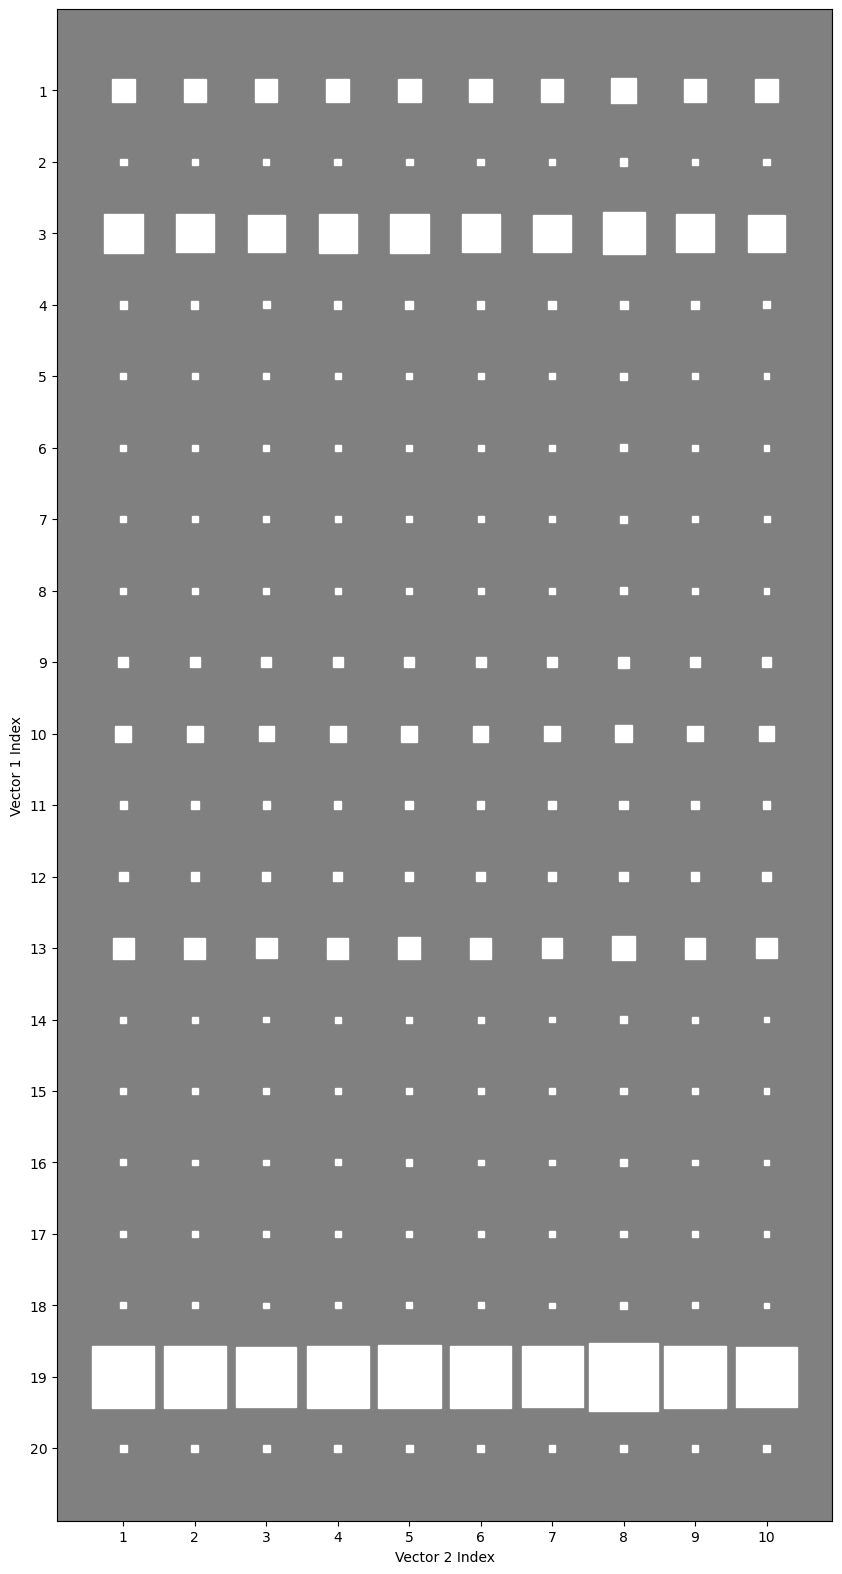

In [307]:
def calc_P_matrix(R):
    # Calculate the denominator: PK-1 Rik for each row
    denominator = np.sum(R, axis=1)

    # Ensure there are no division by zero errors
    denominator[denominator == 0] = 1

    # Calculate the P matrix using broadcasting
    P = R / denominator[:, np.newaxis]

    return P

def calc_H(P):

    # Calculate the entropy formula using broadcasting
    K = P.shape[1]
    H = -np.sum(P * np.log(K) * P, axis=1)
#     print(H.shape)

    return H
def calc_D(H):
    return 1-H

def hinton(matrix, max_weight=None, ax=None):
    if ax is None:
        ax = plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size, facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

    # Add labels to the axes
    ax.set_xticks(np.arange(matrix.shape[0]), minor=False)
    ax.set_yticks(np.arange(matrix.shape[1]), minor=False)
    ax.set_xticklabels(range(1, matrix.shape[0] + 1))
    ax.set_yticklabels(range(1, matrix.shape[1] + 1))
    plt.xlabel('Vector 2 Index')
    plt.ylabel('Vector 1 Index')

R = R_mlp_vq
Pi = calc_P_matrix(R.T)
Pj = calc_P_matrix(R)
print(Pi.shape)
Hd = calc_H(Pi)
Hc = calc_H(Pj)
D = calc_D(Hd)
C = calc_D(Hc)
print(D.shape)
print(C.shape)
diagram = D[:, np.newaxis] * C
plt.figure(figsize=(10, 40))
hinton(diagram.T)
plt.show()


In [28]:
Origin, REC, latents = rebuild_TS(vq, train_data, args)
latents.shape

torch.Size([800, 2, 10])

In [30]:
latents_reshaped = latents.reshape(-1, args.latent_dims)

In [29]:
umap_result = []
for i in range(args.n_channels):
    latent_grp = latents[:,i,:]
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(latent_grp)
    umap_result.append(embedding)


/home/anis/mambaforge/envs/tenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [31]:
import umap
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(latents_reshaped)


/home/anis/mambaforge/envs/tenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


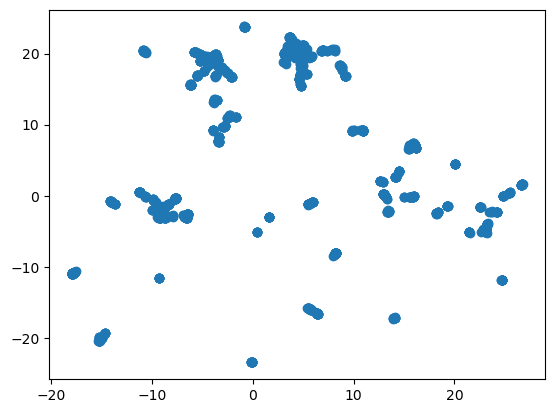

In [32]:
plt.scatter(umap_result[:,0], umap_result[:,1])

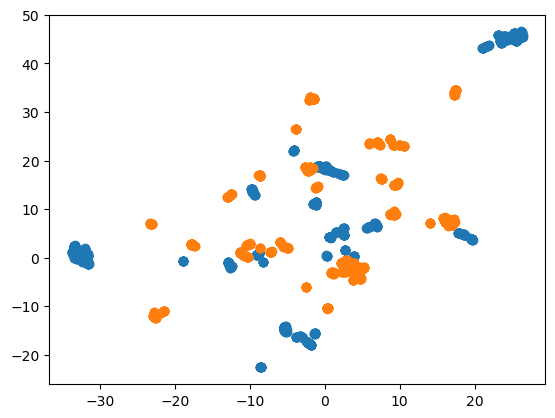

In [26]:
for embed in umap_result:
    plt.scatter(embed[:,0], embed[:,1])

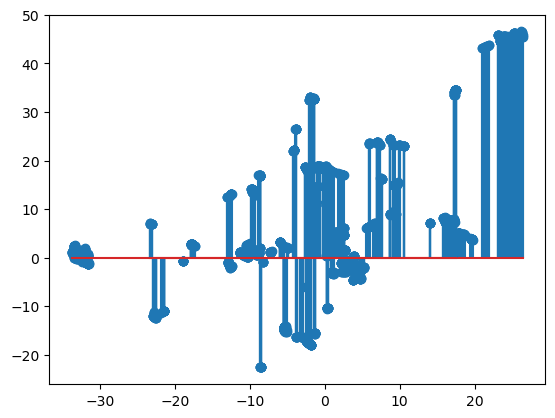

In [27]:
for embed in umap_result:
    plt.stem(embed[:,0], embed[:,1].T)